In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna tpot scikit-learn shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=1ce9a9b20d08a3efd5ce72b5806bfea0828cda221308e9326046457d7ccffdf9
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalli

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import TimeSeriesSplit, KFold
#from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, silhouette_score

from tpot import TPOTRegressor

import optuna
#from optuna.visualization import plot_optimization_history, plot_slice, plot_param_importance


# Orig (df_dbscanned)

In [5]:
df_dbscanned = pd.read_csv("/content/drive/MyDrive/AI 221 Project/01 Colab Codes/Model Runs [Josh]/multicities3_alpha_final_df.csv")
df_dbscanned.head()

,loc,date,day,month,year,latitude,longitude,MEAN__ALLSKY_KT,MEAN__ALLSKY_SFC_LW_DWN,MEAN__ALLSKY_SFC_SW_DIFF,...,MEAN__WS2M,MAX__WS2M_MAX,MIN__WS2M_MIN,MEAN__WS50M,MAX__WS50M_MAX,MIN__WS50M_MIN,cases,moving_average,deviation,anomaly
0,BULACAN,10/01/2016,10,1,2016,15.000000,121.083333,0.601429,392.362857,1.388571,...,1.031429,1.79,0.30,4.250000,5.88,1.25,97,NaN,NaN,1
1,RIZAL,10/01/2016,10,1,2016,14.650000,121.250000,0.562857,399.490000,1.647143,...,1.270000,2.02,0.47,4.371429,5.93,1.68,93,NaN,NaN,1
2,QUEZON CITY,10/01/2016,10,1,2016,14.651055,121.048625,0.562857,399.490000,1.647143,...,1.270000,2.02,0.47,4.371429,5.93,1.68,58,NaN,NaN,1
3,BULACAN,17/01/2016,17,1,2016,15.000000,121.083333,0.592857,397.481429,1.620000,...,0.977143,1.54,0.53,3.905714,5.07,1.16,58,NaN,18.50,1
4,RIZAL,17/01/2016,17,1,2016,14.650000,121.250000,0.531429,406.765714,1.702857,...,1.188571,1.84,0.72,4.020000,5.14,1.78,78,76.5,6.25,1


In [6]:
df_dbscanned.columns

Index(['loc', 'date', 'day', 'month', 'year', 'latitude', 'longitude',
       'MEAN__ALLSKY_KT', 'MEAN__ALLSKY_SFC_LW_DWN',
       'MEAN__ALLSKY_SFC_SW_DIFF', 'MEAN__ALLSKY_SFC_SW_DNI',
       'MEAN__ALLSKY_SFC_SW_DWN', 'MEAN__ALLSKY_SFC_UV_INDEX',
       'MEAN__CLOUD_AMT', 'MEAN__CLOUD_AMT_DAY', 'MEAN__CLOUD_AMT_NIGHT',
       'MEAN__DISPH', 'MEAN__EVLAND', 'MEAN__EVPTRNS', 'MEAN__GWETPROF',
       'MEAN__GWETROOT', 'MEAN__GWETTOP', 'MEAN__MIDDAY_INSOL',
       'MEAN__PRECTOTCORR', 'SUM__PW', 'MEAN__RH2M', 'MEAN__T10M',
       'MAX__T10M_MAX', 'MIN__T10M_MIN', 'MEAN__T2M', 'MEAN__T2MDEW',
       'SUM__T2MWET', 'MAX__T2M_MAX', 'MIN__T2M_MIN', 'MEAN__T2M_RANGE',
       'SUM__TQV', 'MEAN__TROPQ', 'MEAN__TROPT', 'MEAN__TS', 'MAX__TS_MAX',
       'MIN__TS_MIN', 'MEAN__WS10M', 'MAX__WS10M_MAX', 'MIN__WS10M_MIN',
       'MEAN__WS2M', 'MAX__WS2M_MAX', 'MIN__WS2M_MIN', 'MEAN__WS50M',
       'MAX__WS50M_MAX', 'MIN__WS50M_MIN', 'cases', 'moving_average',
       'deviation', 'anomaly'],
      dty

In [7]:
# Fill NA values as DBSCAN cannot handle NA values
print(f'Shape:{df_dbscanned.shape}')
df_dbscanned.dropna(inplace=True)
print(f'Shape:{df_dbscanned.shape}')

Shape:(783, 54)
Shape:(779, 54)


In [8]:
df_dbscanned['date'] = pd.to_datetime(df_dbscanned['date'])
df_dbscanned.set_index('date', inplace=True)

encoder_year = OrdinalEncoder()
encoder_day = OrdinalEncoder()
encoder_month = OrdinalEncoder()
encoder_loc = LabelEncoder()

df_dbscanned['year'] = encoder_year.fit_transform(df_dbscanned[['year']])
df_dbscanned['day'] = encoder_day.fit_transform(df_dbscanned[['day']])
df_dbscanned['month'] = encoder_month.fit_transform(df_dbscanned[['month']])
df_dbscanned['loc'] = encoder_loc.fit_transform(df_dbscanned['loc'])

print(f'0:{encoder_loc.inverse_transform([0])}')
print(f'1:{encoder_loc.inverse_transform([1])}')
print(f'2:{encoder_loc.inverse_transform([2])}')

0:['BULACAN']
1:['QUEZON CITY']
2:['RIZAL']


<ipython-input-8-b535939b4414>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_dbscanned['date'] = pd.to_datetime(df_dbscanned['date'])


In [9]:
df_dbscanned.head()

,loc,day,month,year,latitude,longitude,MEAN__ALLSKY_KT,MEAN__ALLSKY_SFC_LW_DWN,MEAN__ALLSKY_SFC_SW_DIFF,MEAN__ALLSKY_SFC_SW_DNI,...,MEAN__WS2M,MAX__WS2M_MAX,MIN__WS2M_MIN,MEAN__WS50M,MAX__WS50M_MAX,MIN__WS50M_MIN,cases,moving_average,deviation,anomaly
date,,,,,,,,,,,,,,,,,,,,,
2016-01-17,2,16.0,0.0,0.0,14.650000,121.250000,0.531429,406.765714,1.702857,4.598571,...,1.188571,1.84,0.72,4.020000,5.14,1.78,78,76.50,6.25,1
2016-01-17,1,16.0,0.0,0.0,14.651055,121.048625,0.531429,406.765714,1.702857,4.598571,...,1.188571,1.84,0.72,4.020000,5.14,1.78,81,71.75,12.25,1
2016-01-24,0,23.0,0.0,0.0,15.000000,121.083333,0.528571,400.065714,1.607143,4.670000,...,1.215714,2.70,0.15,4.781429,9.38,0.27,76,68.75,2.75,1
2016-01-24,2,23.0,0.0,0.0,14.650000,121.250000,0.531429,404.571429,1.812857,4.470000,...,1.460000,3.02,0.43,4.855714,9.18,1.00,111,73.25,24.50,1
2016-01-24,1,23.0,0.0,0.0,14.651055,121.048625,0.531429,404.571429,1.812857,4.470000,...,1.460000,3.02,0.43,4.855714,9.18,1.00,85,86.50,3.25,1


# Scaling (df_standardized)

In [11]:
# List columns to exclude from standardization
columns_to_exclude = ['loc', 'day', 'month', 'year', 'cases', 'anomaly']
columns_to_standardize = df_dbscanned.columns.difference(columns_to_exclude)
features_to_standardize = df_dbscanned[columns_to_standardize]
features_to_exclude = df_dbscanned[columns_to_exclude]

# Standardize the selected features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features_to_standardize)

df_standardized = pd.DataFrame(features_standardized, columns=columns_to_standardize, index=df_dbscanned.index)
df_standardized = pd.concat([features_to_exclude, df_standardized], axis=1)
df_standardized  = df_standardized[df_dbscanned.columns]

df_standardized.head()

,loc,day,month,year,latitude,longitude,MEAN__ALLSKY_KT,MEAN__ALLSKY_SFC_LW_DWN,MEAN__ALLSKY_SFC_SW_DIFF,MEAN__ALLSKY_SFC_SW_DNI,...,MEAN__WS2M,MAX__WS2M_MAX,MIN__WS2M_MIN,MEAN__WS50M,MAX__WS50M_MAX,MIN__WS50M_MIN,cases,moving_average,deviation,anomaly
date,,,,,,,,,,,,,,,,,,,,,
2016-01-17,2,16.0,0.0,0.0,-0.708946,1.394405,0.512301,-0.688396,-1.328163,0.629033,...,-0.276527,-0.872165,0.605117,-0.369154,-1.080391,-0.120140,78,-0.379715,-0.595414,1
2016-01-17,1,16.0,0.0,0.0,-0.702540,-0.895502,0.512301,-0.688396,-1.328163,0.629033,...,-0.276527,-0.872165,0.605117,-0.369154,-1.080391,-0.120140,81,-0.420728,-0.393035,1
2016-01-24,0,23.0,0.0,0.0,1.416936,-0.500829,0.478897,-1.415266,-1.553825,0.675572,...,-0.200409,0.352830,-1.069486,0.218763,0.765029,-1.142710,76,-0.446632,-0.713469,1
2016-01-24,2,23.0,0.0,0.0,-0.708946,1.394405,0.512301,-0.926450,-1.068820,0.545263,...,0.484654,0.808642,-0.246874,0.276121,0.677981,-0.648355,111,-0.407777,0.020156,1
2016-01-24,1,23.0,0.0,0.0,-0.702540,-0.895502,0.512301,-0.926450,-1.068820,0.545263,...,0.484654,0.808642,-0.246874,0.276121,0.677981,-0.648355,85,-0.293371,-0.696604,1


# Univariate Corr (df_features1)

Original Features:  53


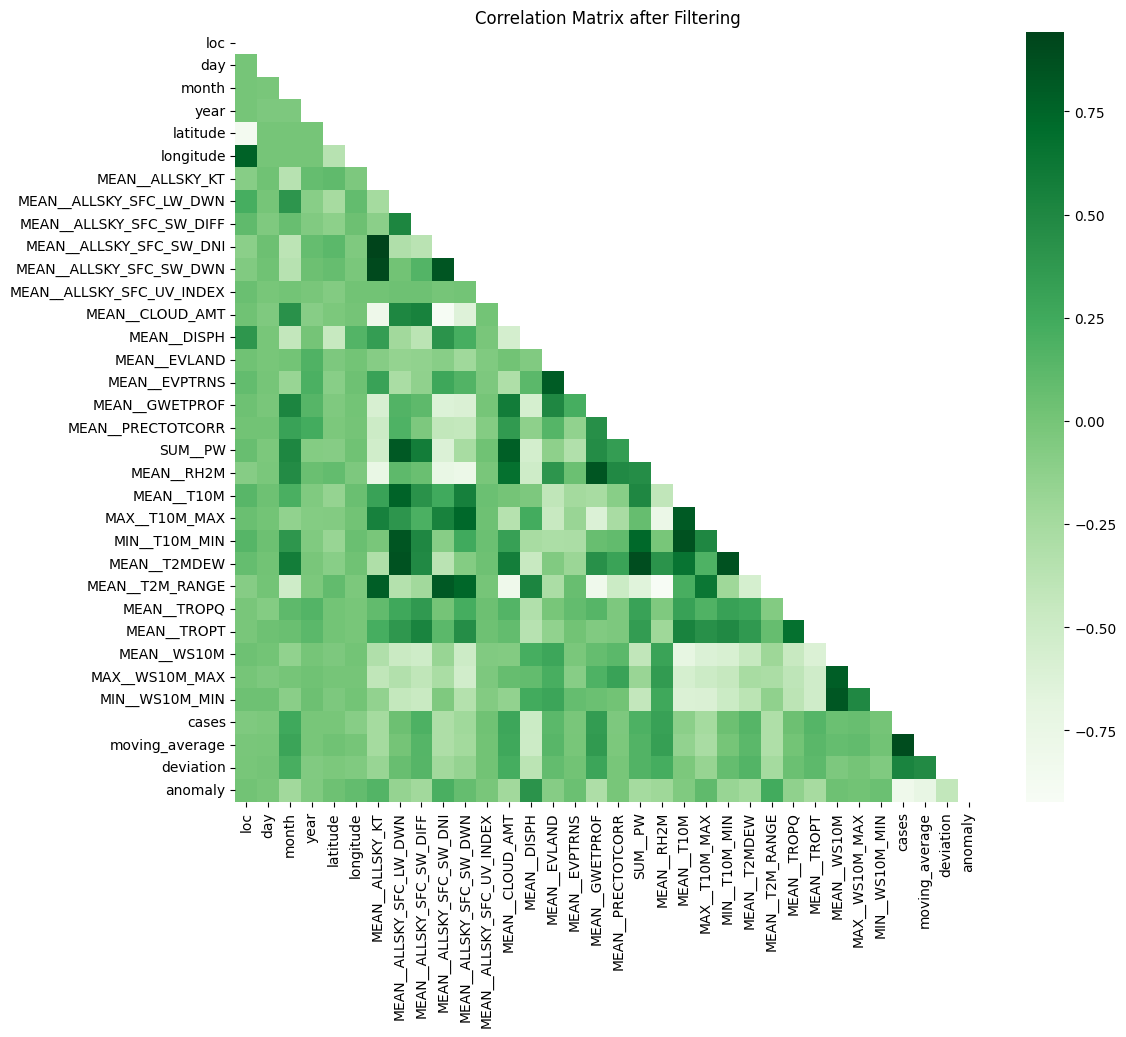

Reduced Features:  34
Highly Correlated Features: 
 [('MEAN__ALLSKY_KT', 'MEAN__MIDDAY_INSOL'), ('MEAN__ALLSKY_SFC_SW_DNI', 'MEAN__CLOUD_AMT_DAY'), ('MEAN__ALLSKY_SFC_SW_DWN', 'MEAN__MIDDAY_INSOL'), ('MEAN__CLOUD_AMT', 'MEAN__CLOUD_AMT_DAY'), ('MEAN__CLOUD_AMT', 'MEAN__CLOUD_AMT_NIGHT'), ('MEAN__GWETPROF', 'MEAN__GWETROOT'), ('MEAN__GWETPROF', 'MEAN__GWETTOP'), ('MEAN__GWETROOT', 'MEAN__GWETTOP'), ('SUM__PW', 'SUM__TQV'), ('MEAN__T10M', 'MEAN__T2M'), ('MEAN__T10M', 'MEAN__TS'), ('MAX__T10M_MAX', 'MAX__T2M_MAX'), ('MAX__T10M_MAX', 'MAX__TS_MAX'), ('MIN__T10M_MIN', 'SUM__T2MWET'), ('MIN__T10M_MIN', 'MIN__T2M_MIN'), ('MIN__T10M_MIN', 'MIN__TS_MIN'), ('MEAN__T2M', 'MEAN__TS'), ('MAX__T2M_MAX', 'MAX__TS_MAX'), ('MIN__T2M_MIN', 'MIN__TS_MIN'), ('MEAN__WS10M', 'MEAN__WS2M'), ('MEAN__WS10M', 'MEAN__WS50M'), ('MAX__WS10M_MAX', 'MAX__WS2M_MAX'), ('MAX__WS10M_MAX', 'MAX__WS50M_MAX'), ('MIN__WS10M_MIN', 'MIN__WS2M_MIN'), ('MIN__WS10M_MIN', 'MIN__WS50M_MIN'), ('MAX__WS2M_MAX', 'MAX__WS50M_MAX')]


In [12]:
import seaborn as sns

ss_features_with_target_df = df_standardized.copy()
ss_features_with_target_df['cases'] = df_standardized['cases'].values

ut = np.triu(df_standardized.corr())
print("Original Features: ", len(ut))

# Create a mask to identify highly correlated features
corr_matrix = df_standardized.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Exclude diagonal by setting k=1

# Get pairs of highly correlated features
high_corr_features = [(corr_matrix.columns[i], corr_matrix.columns[j])
                      for i, j in zip(*np.where(mask & (corr_matrix > 0.95)))]

# Drop highly correlated features
df_features1 = df_standardized.drop(columns=[pair[1] for pair in high_corr_features])

#orted_final_merged_df_filtered = final_df.drop(columns=[pair[1] for pair in high_corr_features]) # cleaned_sorted_final_merged_df

# Plot the correlation matrix of the filtered features
ut = np.triu(df_features1.corr())
fig = plt.figure(figsize=(12, 10))
sns.heatmap(df_features1.corr(), cmap='Greens', annot=False, cbar=True, mask=ut)
plt.title('Correlation Matrix after Filtering')
plt.show()

print("Reduced Features: ", len(ut))
print(f"Highly Correlated Features: \n {high_corr_features}")

# VIF (df_features2)

The Variance Inflation Factor (VIF) is a measure used to detect the presence and severity of multicollinearity in a set of regression variables. Multicollinearity occurs when two or more predictor variables in a statistical model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy. High multicollinearity can affect the stability and interpretation of the coefficients in a regression model.

In [13]:
df_features2 = df_standardized.drop(['cases','loc'], axis=1)

# Function to calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF for the initial features
vif_data = calculate_vif(df_features2)
print("Initial VIF data:\n", vif_data)

# Remove features with high VIF (>10) iteratively
threshold = 10
iteration = 0
while vif_data['VIF'].max() > threshold:
    feature_to_remove = vif_data.sort_values('VIF', ascending=False).iloc[0]['feature']
    df_features2 = df_features2.drop(columns=[feature_to_remove])
    vif_data = calculate_vif(df_features2)
    iteration += 1

print(f"Final VIF data after {iteration} iterations:\n", vif_data)

Initial VIF data:
                       feature            VIF
0                         day       3.363480
1                       month       6.112678
2                        year       3.340188
3                    latitude      17.018967
4                   longitude       1.188708
5             MEAN__ALLSKY_KT     121.561110
6     MEAN__ALLSKY_SFC_LW_DWN      16.709701
7    MEAN__ALLSKY_SFC_SW_DIFF     109.245961
8     MEAN__ALLSKY_SFC_SW_DNI     659.241586
9     MEAN__ALLSKY_SFC_SW_DWN     319.403886
10  MEAN__ALLSKY_SFC_UV_INDEX       1.062441
11            MEAN__CLOUD_AMT    4935.915578
12        MEAN__CLOUD_AMT_DAY    1251.153830
13      MEAN__CLOUD_AMT_NIGHT    1431.082286
14                MEAN__DISPH       9.491930
15               MEAN__EVLAND      18.369916
16              MEAN__EVPTRNS      17.958856
17             MEAN__GWETPROF     572.812814
18             MEAN__GWETROOT     815.806058
19              MEAN__GWETTOP     300.726596
20         MEAN__MIDDAY_INSOL      4

In [14]:
df_features2['cases'] = df_standardized['cases']
df_features2['loc'] = df_standardized['loc']
df_features2.head()

,day,month,year,latitude,longitude,MEAN__ALLSKY_SFC_LW_DWN,MEAN__ALLSKY_SFC_SW_DIFF,MEAN__ALLSKY_SFC_UV_INDEX,MEAN__CLOUD_AMT_NIGHT,MEAN__DISPH,...,MIN__T10M_MIN,MEAN__TROPQ,MEAN__TROPT,MAX__WS2M_MAX,MIN__WS2M_MIN,moving_average,deviation,anomaly,cases,loc
date,,,,,,,,,,,,,,,,,,,,,
2016-01-17,16.0,0.0,0.0,-0.708946,1.394405,-0.688396,-1.328163,0.004885,-0.722095,0.642996,...,-0.520662,-0.462532,0.162598,-0.872165,0.605117,-0.379715,-0.595414,1,78,2
2016-01-17,16.0,0.0,0.0,-0.702540,-0.895502,-0.688396,-1.328163,0.004885,-0.722095,0.642996,...,-0.520662,-0.462532,0.162598,-0.872165,0.605117,-0.420728,-0.393035,1,81,1
2016-01-24,23.0,0.0,0.0,1.416936,-0.500829,-1.415266,-1.553825,0.001332,-1.322978,-0.434046,...,-1.815717,-0.462532,0.178111,0.352830,-1.069486,-0.446632,-0.713469,1,76,0
2016-01-24,23.0,0.0,0.0,-0.708946,1.394405,-0.926450,-1.068820,0.009229,-1.394719,0.669054,...,-1.308957,-0.462532,0.143982,0.808642,-0.246874,-0.407777,0.020156,1,111,2
2016-01-24,23.0,0.0,0.0,-0.702540,-0.895502,-0.926450,-1.068820,0.009229,-1.394719,0.669054,...,-1.308957,-0.462532,0.143982,0.808642,-0.246874,-0.293371,-0.696604,1,85,1


# Splitting

In [15]:
test_size = 0.3

df_db = df_dbscanned.sort_index()
split_index_db = int(len(df_db) * (1 - test_size))
train_df_db = df_db.iloc[:split_index_db]
test_df_db = df_db.iloc[split_index_db:]

print("Number of rows train db:", train_df_db['loc'].value_counts())
print("Number of rows test db:", test_df_db['loc'].value_counts())

df_st = df_standardized.sort_index()
split_index_st = int(len(df_st) * (1 - test_size))
train_df_st = df_st.iloc[:split_index_st]
test_df_st = df_st.iloc[split_index_st:]

print("Number of rows train st:", train_df_st['loc'].value_counts())
print("Number of rows test st:", test_df_st['loc'].value_counts())

df_f1 = df_features1.sort_index()
split_index_f1 = int(len(df_f1) * (1 - test_size))
train_df_f1 = df_f1.iloc[:split_index_f1]
test_df_f1 = df_f1.iloc[split_index_f1:]

print("Number of rows train f1:", train_df_f1['loc'].value_counts())
print("Number of rows test f1:", test_df_f1['loc'].value_counts())

df_f2 = df_features2.sort_index()
split_index_f2 = int(len(df_f2) * (1 - test_size))
train_df_f2 = df_f2.iloc[:split_index_f2]
test_df_f2 = df_f2.iloc[split_index_f2:]

print("Number of rows train f2:", train_df_f2['loc'].value_counts())
print("Number of rows test f2:", test_df_f2['loc'].value_counts())

Number of rows train db: loc
2    182
1    182
0    181
Name: count, dtype: int64
Number of rows test db: loc
0    78
2    78
1    78
Name: count, dtype: int64
Number of rows train st: loc
2    182
1    182
0    181
Name: count, dtype: int64
Number of rows test st: loc
0    78
2    78
1    78
Name: count, dtype: int64
Number of rows train f1: loc
2    182
1    182
0    181
Name: count, dtype: int64
Number of rows test f1: loc
0    78
2    78
1    78
Name: count, dtype: int64
Number of rows train f2: loc
2    182
1    182
0    181
Name: count, dtype: int64
Number of rows test f2: loc
0    78
2    78
1    78
Name: count, dtype: int64


In [16]:
y_train_db, y_test_db = train_df_db['cases'], test_df_db['cases']
y_train_db_cc, y_test_db_cc = train_df_db[['cases', 'loc']], test_df_db[['cases', 'loc']]
y_train_db_ = y_train_db.values.ravel()
y_test_db_ = y_test_db.values.ravel()
X_train_db, X_test_db = train_df_db.drop(columns=['cases']), test_df_db.drop(columns=['cases'])

y_train_st, y_test_st = train_df_st['cases'], test_df_st['cases']
y_train_st_cc, y_test_st_cc = train_df_st[['cases', 'loc']], test_df_st[['cases', 'loc']]
y_train_st_ = y_train_st.values.ravel()
y_test_st_ = y_test_st.values.ravel()
X_train_st, X_test_st = train_df_st.drop(columns=['cases']), test_df_st.drop(columns=['cases'])

y_train_f1, y_test_f1 = train_df_f1['cases'], test_df_f1['cases']
y_train_f1_cc, y_test_f1_cc = train_df_f1[['cases', 'loc']], test_df_f1[['cases', 'loc']]
y_train_f1_ = y_train_f1.values.ravel()
y_test_f1_ = y_test_f1.values.ravel()
X_train_f1, X_test_f1 = train_df_f1.drop(columns=['cases']), test_df_f1.drop(columns=['cases'])

y_train_f2, y_test_f2 = train_df_f2['cases'], test_df_f2['cases']
y_train_f2_cc, y_test_f2_cc = train_df_f2[['cases', 'loc']], test_df_f2[['cases', 'loc']]
y_train_f2_ = y_train_f2.values.ravel()
y_test_f2_ = y_test_f2.values.ravel()
X_train_f2, X_test_f2 = train_df_f2.drop(columns=['cases']), test_df_f2.drop(columns=['cases'])

In [17]:
print("db")
print("Indexes are the same and aligned:", y_train_db_cc.index.equals(X_train_db.index))
print("Loc is the same and aligned:", y_train_db_cc['loc'].equals(X_train_db['loc']))

print("st")
print("Indexes are the same and aligned:", y_train_st_cc.index.equals(X_train_st.index))
print("Loc is the same and aligned:", y_train_st_cc['loc'].equals(X_train_st['loc']))

print("f1")
print("Indexes are the same and aligned:", y_train_f1_cc.index.equals(X_train_f1.index))
print("Loc is the same and aligned:", y_train_f1_cc['loc'].equals(X_train_f1['loc']))

print("f2")
print("Indexes are the same and aligned:", y_train_f2_cc.index.equals(X_train_f2.index))
print("Loc is the same and aligned:", y_train_f2_cc['loc'].equals(X_train_f2['loc']))

db
Indexes are the same and aligned: True
Loc is the same and aligned: True
st
Indexes are the same and aligned: True
Loc is the same and aligned: True
f1
Indexes are the same and aligned: True
Loc is the same and aligned: True
f2
Indexes are the same and aligned: True
Loc is the same and aligned: True


In [18]:
print("Train Features (X_train):")
display(X_train_db.tail())
display(y_train_db.tail())
print("Test Featues (X_test)")
display(X_test_db.head())
display(y_test_db.head())

Train Features (X_train):


,loc,day,month,year,latitude,longitude,MEAN__ALLSKY_KT,MEAN__ALLSKY_SFC_LW_DWN,MEAN__ALLSKY_SFC_SW_DIFF,MEAN__ALLSKY_SFC_SW_DNI,...,MIN__WS10M_MIN,MEAN__WS2M,MAX__WS2M_MAX,MIN__WS2M_MIN,MEAN__WS50M,MAX__WS50M_MAX,MIN__WS50M_MIN,moving_average,deviation,anomaly
date,,,,,,,,,,,,,,,,,,,,,
2019-07-07,2,6.0,6.0,3.0,14.650000,121.250000,0.495714,420.494286,2.268571,4.052857,...,0.01,1.097143,2.27,0.00,3.201429,6.56,0.02,83.25,3.25,1
2019-07-07,1,6.0,6.0,3.0,14.651055,121.048625,0.495714,420.494286,2.268571,4.052857,...,0.01,1.097143,2.27,0.00,3.201429,6.56,0.02,78.75,22.50,1
2019-07-14,0,13.0,6.0,3.0,15.000000,121.083333,0.621429,414.254286,2.251429,5.904286,...,0.29,0.735714,1.74,0.02,2.875714,5.62,0.36,87.50,43.50,1
2019-07-14,2,13.0,6.0,3.0,14.650000,121.250000,0.571429,420.000000,2.398571,4.891429,...,0.18,0.955714,1.83,0.04,2.975714,5.24,0.38,82.50,23.25,1
2019-07-14,1,13.0,6.0,3.0,14.651055,121.048625,0.571429,420.000000,2.398571,4.891429,...,0.18,0.955714,1.83,0.04,2.975714,5.24,0.38,84.75,28.75,1


date
2019-07-07     82
2019-07-07    110
2019-07-14     39
2019-07-14    108
2019-07-14    124
Name: cases, dtype: int64

Test Featues (X_test)


,loc,day,month,year,latitude,longitude,MEAN__ALLSKY_KT,MEAN__ALLSKY_SFC_LW_DWN,MEAN__ALLSKY_SFC_SW_DIFF,MEAN__ALLSKY_SFC_SW_DNI,...,MIN__WS10M_MIN,MEAN__WS2M,MAX__WS2M_MAX,MIN__WS2M_MIN,MEAN__WS50M,MAX__WS50M_MAX,MIN__WS50M_MIN,moving_average,deviation,anomaly
date,,,,,,,,,,,,,,,,,,,,,
2019-07-21,0,20.0,6.0,3.0,15.000000,121.083333,0.337143,417.725714,2.410000,1.545714,...,0.09,1.225714,2.70,0.12,4.801429,9.99,0.09,95.25,46.00,1
2019-07-21,2,20.0,6.0,3.0,14.650000,121.250000,0.365714,418.348571,2.491429,1.814286,...,0.11,1.494286,3.51,0.07,4.705714,10.62,0.18,75.00,75.00,1
2019-07-21,1,20.0,6.0,3.0,14.651055,121.048625,0.365714,418.348571,2.491429,1.814286,...,0.11,1.494286,3.51,0.07,4.705714,10.62,0.18,112.00,54.50,1
2019-07-28,0,27.0,6.0,3.0,15.000000,121.083333,0.478571,417.425714,3.327143,2.334286,...,0.66,0.727143,1.23,0.28,2.837143,4.65,0.99,131.50,57.75,1
2019-07-28,2,27.0,6.0,3.0,14.650000,121.250000,0.450000,419.015714,3.102857,2.158571,...,0.84,1.041429,1.64,0.41,3.277143,4.88,1.48,114.75,67.25,1


date
2019-07-21     29
2019-07-21    187
2019-07-21    186
2019-07-28     57
2019-07-28    233
Name: cases, dtype: int64

In [24]:
# Setting parameter
tscv = TimeSeriesSplit(n_splits=5)

In [22]:
from joblib import dump
from google.colab import files

# AutoML training on Orig

In [ ]:
tpot_db = TPOTRegressor(generations=10, population_size=50, verbosity=2, cv=tscv, random_state=42)
tpot_db.fit(X_train_db, y_train_db_)

Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -3868.144401856679

Generation 2 - Current best internal CV score: -3868.144401856679

Generation 3 - Current best internal CV score: -3868.1443425932257

Generation 4 - Current best internal CV score: -3868.1443425932257

Generation 5 - Current best internal CV score: -3793.648037297232

Generation 6 - Current best internal CV score: -3491.636460182252

Generation 7 - Current best internal CV score: -3491.636460182252

Generation 8 - Current best internal CV score: -3491.636460182252

Generation 9 - Current best internal CV score: -3340.9179123530253

Generation 10 - Current best internal CV score: -3340.9179123530253

Best pipeline: SGDRegressor(input_matrix, alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.25, learning_rate=invscaling, loss=huber, penalty=elasticnet, power_t=0.5)


TPOTRegressor(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              generations=10, population_size=50, random_state=42, verbosity=2)

In [ ]:
# import csv

# with open('evaluated_pipelines.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Model', 'Pipeline', 'Internal_CV_Score', 'Score'])
#     for pipeline, score in tpot_db.evaluated_individuals_.items():
#         model_name = pipeline.split('(')[0]  # Extracting model name from pipeline
#         internal_cv_score = score['internal_cv_score']  # Extracting internal CV score from score dict
#         writer.writerow([model_name, pipeline, internal_cv_score, score])

# # Download the CSV file
# files.download('evaluated_pipelines.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_pred_db = tpot_db.predict(X_test_db)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_db_, y_pred_db))
mae = mean_absolute_error(y_test_db_, y_pred_db)
r2 = r2_score(y_test_db, y_pred_db)
print(f"RMSE: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

print("Best Pipeline:")
print(tpot_db.fitted_pipeline_)

RMSE: 58.632933721022155
Mean Absolute Error: 37.280493235009175
R-squared: 0.8843967370093715
Best Pipeline:
Pipeline(steps=[('sgdregressor',
                 SGDRegressor(alpha=0.01, fit_intercept=False, l1_ratio=0.25,
                              loss='huber', penalty='elasticnet', power_t=0.5,
                              random_state=42))])


In [ ]:
tpot_db.export('tpot_db_j.py')
files.download('tpot_db_j.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

X_optuna_test = X_test_db
X_optuna_train = X_train_db
y_optuna_test = y_test_db_
y_optuna_train = y_train_db_
pipeline = tpot_db.fitted_pipeline_

#set_param_recursive(pipeline.steps, 'random_state', 42)
pipeline.fit(X_optuna_train, y_optuna_train)
y_optuna_pred = pipeline.predict(X_optuna_test)

locations = X_optuna_train['loc'].unique()
mse = mean_squared_error(y_optuna_test, y_optuna_pred)
mae = mean_absolute_error(y_optuna_test, y_optuna_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_optuna_test, y_optuna_pred)

print(f"All metrics:")
print(f"  MSE CV: {mse}")
print(f"  MAE CV: {mae}")
print(f"  RMSE CV: {rmse}")
print(f"  R2 CV: {r2}")

y_optuna_test = y_test_db_cc
y_optuna_train = y_train_db_cc

for location in locations:

    X_loc_train = X_optuna_train[X_optuna_train['loc']==location]
    y_loc_train = y_optuna_train[y_optuna_train['loc']==location]
    X_loc_test = X_optuna_test[X_optuna_test['loc']==location]
    y_loc_test = y_optuna_test[y_optuna_test['loc']==location]

    y_loc_train = y_loc_train.drop(columns=['loc'])
    y_loc_test = y_loc_test.drop(columns=['loc'])

    y_train_total = []
    y_test_total = []
    y_pred_total = []

    #set_param_recursive(pipeline.steps, 'random_state', 42)
    pipeline.fit(X_loc_train, y_loc_train)
    y_loc_pred = pipeline.predict(X_loc_test)

    # Calculate metrics for each location
    mse = mean_squared_error(y_loc_test, y_loc_pred)
    mae = mean_absolute_error(y_loc_test, y_loc_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_loc_test, y_loc_pred)

    print(f"Location {location} metrics:")
    print(f"  MSE CV: {mse}")
    print(f"  MAE CV: {mae}")
    print(f"  RMSE CV: {rmse}")
    print(f"  R2 CV: {r2}")

All metrics:
  MSE CV: 3437.8209167337773
  MAE CV: 37.280493235009175
  RMSE CV: 58.632933721022155
  R2 CV: 0.8843967370093715
Location 2 metrics:
  MSE CV: 9742.097494992686
  MAE CV: 44.05773546503222
  RMSE CV: 98.70206428941943
  R2 CV: 0.6610980196359539
Location 1 metrics:
  MSE CV: 3460.331928664204
  MAE CV: 36.825623357827496
  RMSE CV: 58.82458609003725
  R2 CV: 0.9085862147936036
Location 0 metrics:
  MSE CV: 3206.9378755662815
  MAE CV: 38.33488146992272
  RMSE CV: 56.62983202841309
  R2 CV: 0.8581888172665965


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Optuna of Orig

In [25]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

X_train_optuna = X_train_db
y_train_optuna = y_train_db
X_test_optuna = X_test_db
y_test_optuna = y_test_db

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-6, 1e-1)#, log=True)
    eta0 = trial.suggest_float('eta0', 1e-4, 1e-1)#, log=True)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive'])
    loss = trial.suggest_categorical('loss', ['epsilon_insensitive', 'huber', 'squared_error', 'squared_epsilon_insensitive'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    power_t = trial.suggest_float('power_t', 0.1, 1.0)

    # Create the SGDRegressor
    pipeline = SGDRegressor(
        alpha=alpha,
        eta0=eta0,
        fit_intercept=fit_intercept,
        l1_ratio=l1_ratio,
        learning_rate=learning_rate,
        loss=loss,
        penalty=penalty,
        power_t=power_t,
        random_state=42
    )

    errors = []

    for train_index, test_index in tscv.split(X_train_optuna):
        X_train_fold, X_test_fold = X_train_optuna.iloc[train_index], X_train_optuna.iloc[test_index]
        y_train_fold, y_test_fold = y_train_optuna.iloc[train_index].values.ravel(), y_train_optuna.iloc[test_index].values.ravel()

        pipeline.fit(X_train_fold, y_train_fold)
        y_test_pred = pipeline.predict(X_test_fold)

        rmse = np.sqrt(mean_squared_error(y_test_fold, y_test_pred))
        errors.append(rmse)

    return np.mean(errors)

In [26]:
study_db = optuna.create_study(direction='minimize')
study_db.optimize(objective, n_trials=100)

print("Best trial:")
trial = study_db.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-06-21 11:08:24,656] A new study created in memory with name: no-name-ac6af57b-4d01-439f-9e13-0a8e3b450b7d
[I 2024-06-21 11:08:24,740] Trial 0 finished with value: 429.33508387852754 and parameters: {'alpha': 0.0018786906837575642, 'eta0': 0.023175429110309894, 'fit_intercept': False, 'l1_ratio': 0.031819091795412424, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'elasticnet', 'power_t': 0.490129124901417}. Best is trial 0 with value: 429.33508387852754.
[I 2024-06-21 11:08:24,827] Trial 1 finished with value: 76.46761070646843 and parameters: {'alpha': 0.08887105847961328, 'eta0': 0.031516903693107626, 'fit_intercept': False, 'l1_ratio': 0.9263270856710486, 'learning_rate': 'adaptive', 'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'power_t': 0.11688694693271635}. Best is trial 1 with value: 76.46761070646843.
[I 2024-06-21 11:08:24,863] Trial 2 finished with value: 7666653753766163.0 and parameters: {'alpha': 0.07863019183067739, 'eta0': 0.03191059321064723,

Best trial:
  Value:  52.1091668549038
  Params: 
    alpha: 0.03036706384788912
    eta0: 0.0740775358192762
    fit_intercept: True
    l1_ratio: 0.8562935137592158
    learning_rate: adaptive
    loss: huber
    penalty: elasticnet
    power_t: 0.22316734786118997


In [27]:
best_params = trial.params

final_model_db = SGDRegressor(
    alpha=best_params['alpha'],
    eta0=best_params['eta0'],
    fit_intercept=best_params['fit_intercept'],
    l1_ratio=best_params['l1_ratio'],
    learning_rate=best_params['learning_rate'],
    loss=best_params['loss'],
    penalty=best_params['penalty'],
    power_t=best_params['power_t'],
    random_state=42
)

In [30]:
X_optuna_test = X_test_db
X_optuna_train = X_train_db
y_optuna_test = y_test_db_
y_optuna_train = y_train_db_
pipeline = final_model_db
locations = X_optuna_train['loc'].unique()
#set_param_recursive(pipeline.steps, 'random_state', 42)
pipeline.fit(X_optuna_train, y_optuna_train)
y_optuna_pred = pipeline.predict(X_optuna_test)

mse = mean_squared_error(y_optuna_test, y_optuna_pred)
mae = mean_absolute_error(y_optuna_test, y_optuna_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_optuna_test, y_optuna_pred)

print(f"All metrics:")
print(f"  MSE CV: {mse}")
print(f"  MAE CV: {mae}")
print(f"  RMSE CV: {rmse}")
print(f"  R2 CV: {r2}")

y_optuna_test = y_test_db_cc
y_optuna_train = y_train_db_cc

for location in locations:

    X_loc_train = X_optuna_train[X_optuna_train['loc']==location]
    y_loc_train = y_optuna_train[y_optuna_train['loc']==location]
    X_loc_test = X_optuna_test[X_optuna_test['loc']==location]
    y_loc_test = y_optuna_test[y_optuna_test['loc']==location]

    y_loc_train = y_loc_train.drop(columns=['loc'])
    y_loc_test = y_loc_test.drop(columns=['loc'])

    y_train_total = []
    y_test_total = []
    y_pred_total = []

    #set_param_recursive(pipeline.steps, 'random_state', 42)
    pipeline.fit(X_loc_train, y_loc_train)
    y_loc_pred = pipeline.predict(X_loc_test)

    # Calculate metrics for each location
    mse = mean_squared_error(y_loc_test, y_loc_pred)
    mae = mean_absolute_error(y_loc_test, y_loc_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_loc_test, y_loc_pred)

    print(f"Location {location} metrics:")
    print(f"  MSE CV: {mse}")
    print(f"  MAE CV: {mae}")
    print(f"  RMSE CV: {rmse}")
    print(f"  R2 CV: {r2}")

All metrics:
  MSE CV: 3333.3256542738536
  MAE CV: 36.97486241185371
  RMSE CV: 57.73496041631841
  R2 CV: 0.8879105888358669
Location 2 metrics:
  MSE CV: 10647.815335360516
  MAE CV: 39.98887651092223
  RMSE CV: 103.18825192511265
  R2 CV: 0.629590475197041
Location 1 metrics:
  MSE CV: 3167.453722532717
  MAE CV: 33.15938930841769
  RMSE CV: 56.280136127524756
  R2 CV: 0.9163233642864482
Location 0 metrics:
  MSE CV: 3293.8167652005022
  MAE CV: 39.475264157907716
  RMSE CV: 57.39178308086012
  R2 CV: 0.8543470222048763


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
import shap
X_column = pd.DataFrame(X_optuna_test, columns=X_optuna_test.columns)
explainer = shap.Explainer(pipeline.predict, X_column)

shap_values = explainer.shap_values(X_column)
num_features = X_column.shape[1]

PermutationExplainer explainer: 235it [00:15,  8.79it/s]                         


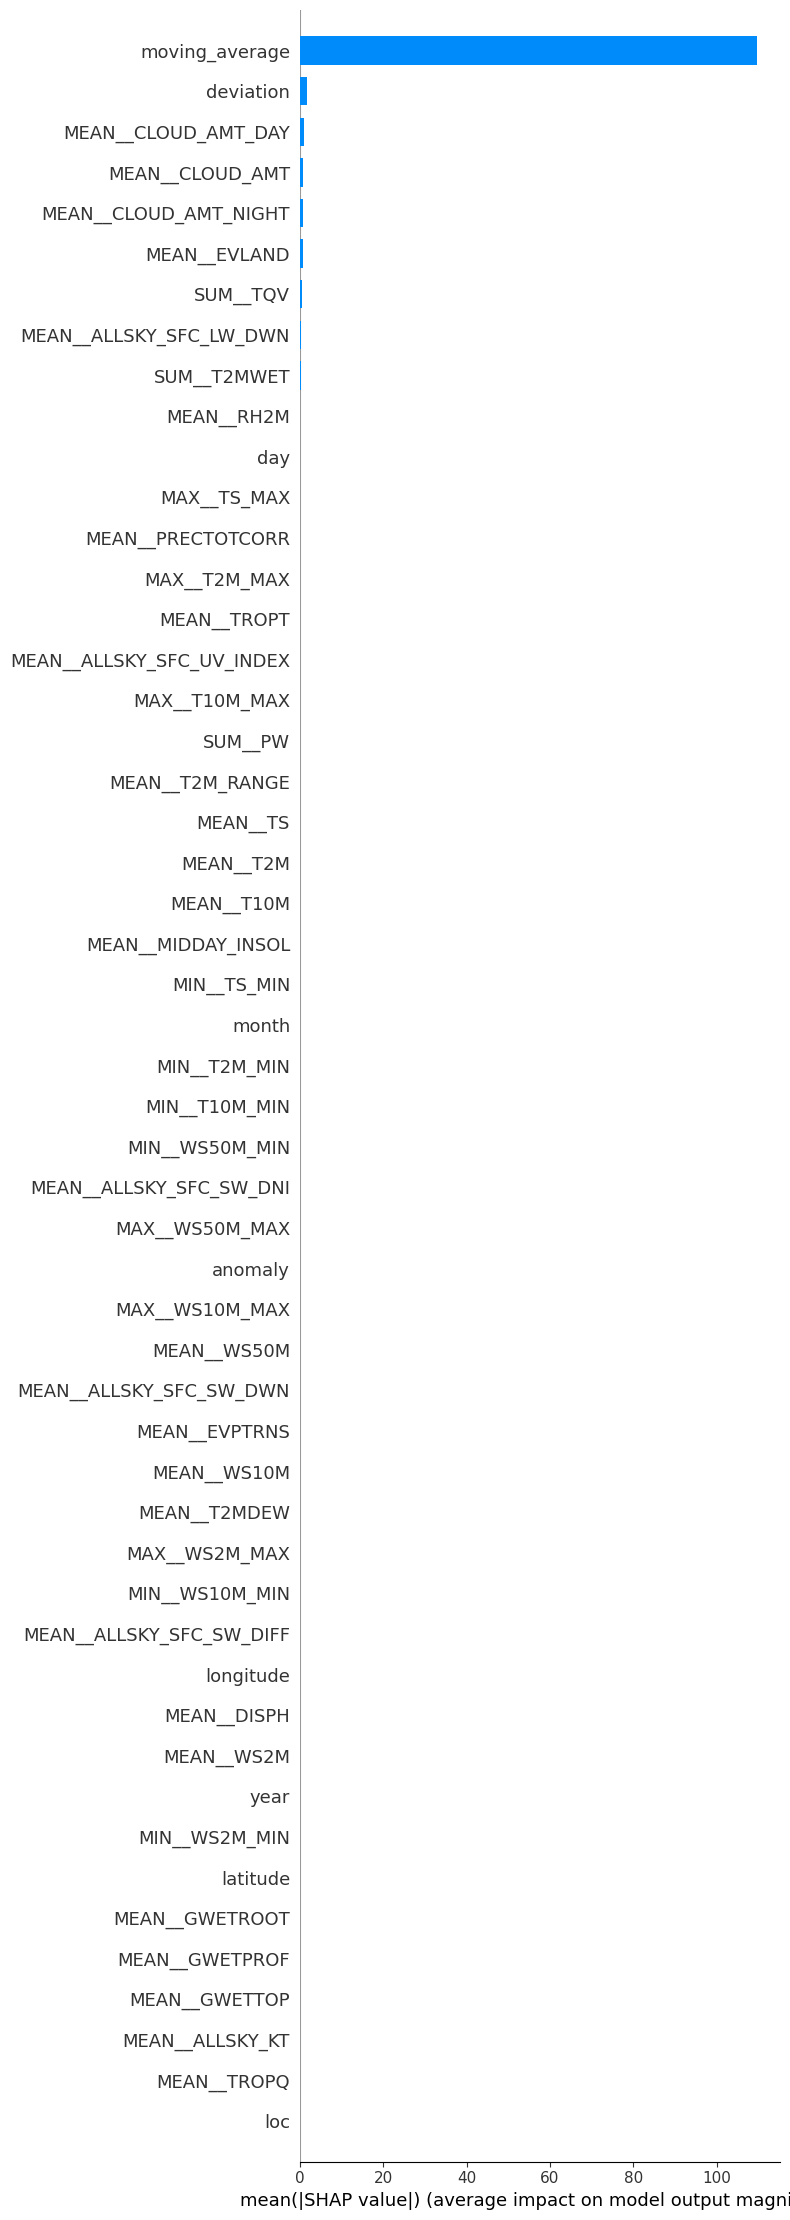

In [ ]:
shap.summary_plot(shap_values, X_column, plot_type="bar", max_display=num_features)

# 2020 PREDICTIONS

In [ ]:
def split_data_by_year(df, year_value=3):
    train_df = df[df['year'] < year_value ]
    test_df = df[df['year'] >= year_value ]

    return train_df, test_df

# Split df_dbscanned
train_df_5_db, test_df_5_db = split_data_by_year(df_dbscanned)
print("Number of rows train db:", train_df_5_db['loc'].value_counts())
print("Number of rows test db:", test_df_5_db['loc'].value_counts())

# Split df_standardized
train_df_5_st, test_df_5_st = split_data_by_year(df_standardized)
print("Number of rows train st:", train_df_5_st['loc'].value_counts())
print("Number of rows test st:", test_df_5_st['loc'].value_counts())

# Split df_features1
train_df_5_f1, test_df_5_f1 = split_data_by_year(df_features1)
print("Number of rows train f1:", train_df_5_f1['loc'].value_counts())
print("Number of rows test f1:", test_df_5_f1['loc'].value_counts())

# Split df_features2
train_df_5_f2, test_df_5_f2 = split_data_by_year(df_features2)
print("Number of rows train f2:", train_df_5_f2['loc'].value_counts())
print("Number of rows test f2:", test_df_5_f2['loc'].value_counts())

Number of rows train db: loc
2    155
1    155
0    154
Name: count, dtype: int64
Number of rows test db: loc
0    105
2    105
1    105
Name: count, dtype: int64
Number of rows train st: loc
2    155
1    155
0    154
Name: count, dtype: int64
Number of rows test st: loc
0    105
2    105
1    105
Name: count, dtype: int64
Number of rows train f1: loc
2    155
1    155
0    154
Name: count, dtype: int64
Number of rows test f1: loc
0    105
2    105
1    105
Name: count, dtype: int64
Number of rows train f2: loc
2    155
1    155
0    154
Name: count, dtype: int64
Number of rows test f2: loc
0    105
2    105
1    105
Name: count, dtype: int64


In [ ]:
def split_X_y(df, target_column='cases'):
    X = df.drop(columns=[target_column]).to_numpy()
    y = df[target_column].to_numpy()
    return X, y

X_train_5_db, y_train_5_db = split_X_y(train_df_5_db)
X_test_5_db, y_test_5_db = split_X_y(test_df_5_db)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


All metrics:
  MSE CV: 2793.287065501781
  MAE CV: 34.348085009094575
  RMSE CV: 52.85155688815402
  R2 CV: 0.881069249623616
Location 2 metrics:
  MSE CV: 6205.886773905331
  MAE CV: 35.36581988683434
  RMSE CV: 78.77745092287088
  R2 CV: 0.7259640105626555


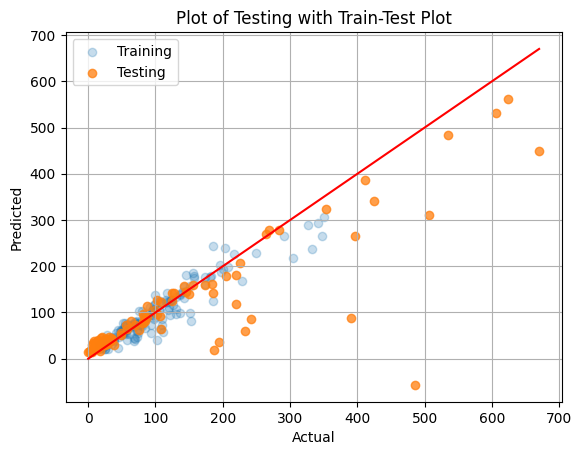

R-squared on Train Data: 0.88612
R-squared on Test Data: 0.72596
RMSE on Train Set: 23.70989729790573
RMSE on Test Set: 78.77745092287088
Mean Absolute Deviation (MAD) on Train Set: 47.518846307874455
Mean Absolute Deviation (MAD) on Test Set: 79.47154016431644


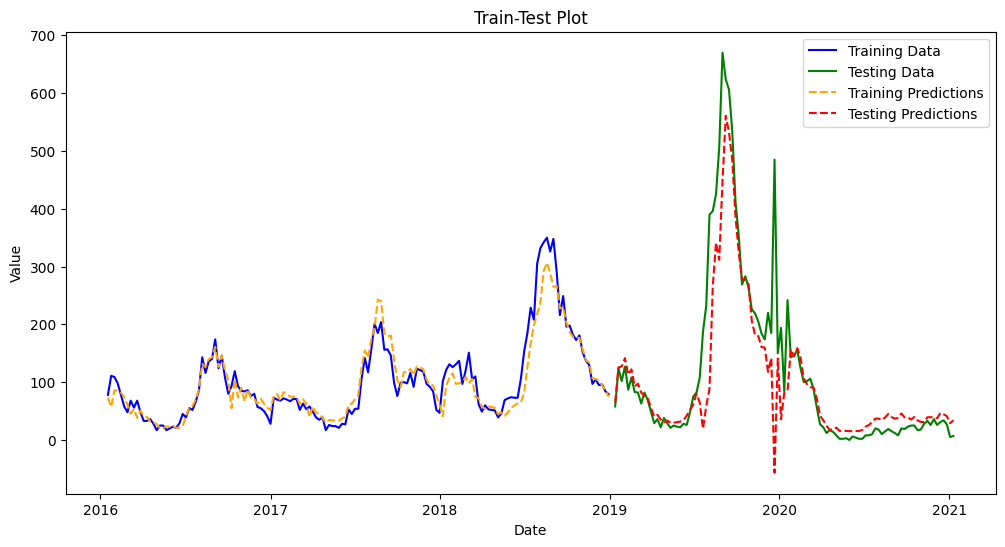

Predictions for location 2 saved to predictions_2.csv
Location 1 metrics:
  MSE CV: 2218.747123970937
  MAE CV: 27.196050339976683
  RMSE CV: 47.103578674777324
  R2 CV: 0.9250033288077029


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


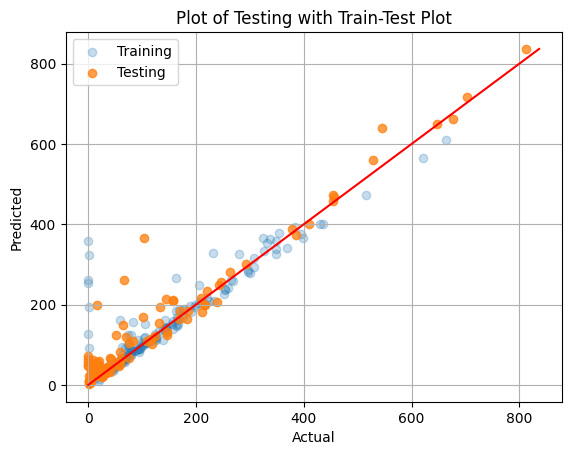

R-squared on Train Data: 0.77941
R-squared on Test Data: 0.92500
RMSE on Train Set: 56.96230808208791
RMSE on Test Set: 47.103578674777324
Mean Absolute Deviation (MAD) on Train Set: 90.42831232460141
Mean Absolute Deviation (MAD) on Test Set: 125.21393890080934


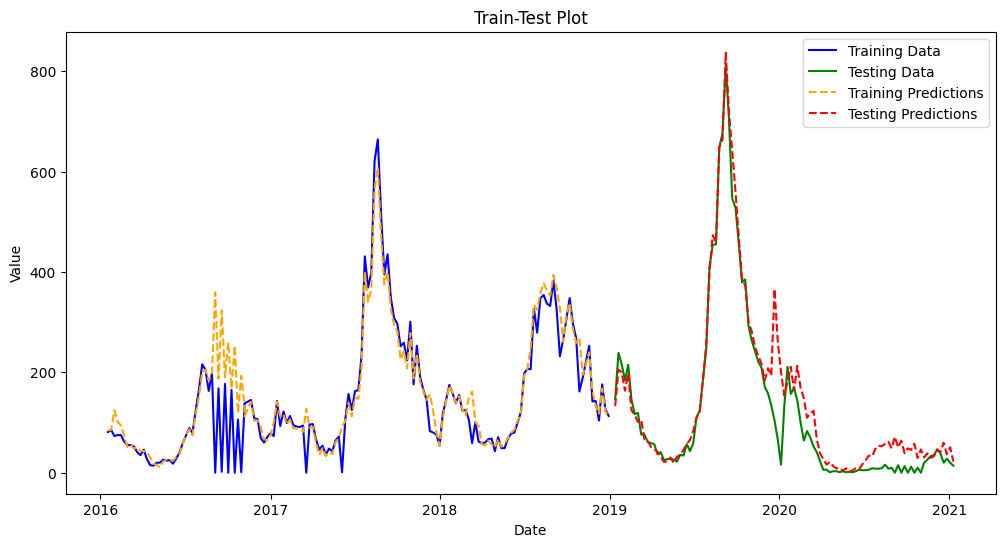

Predictions for location 1 saved to predictions_1.csv
Location 0 metrics:
  MSE CV: 2711.5035631896367
  MAE CV: 34.22054146366229
  RMSE CV: 52.07209966181157
  R2 CV: 0.8510099050458649


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


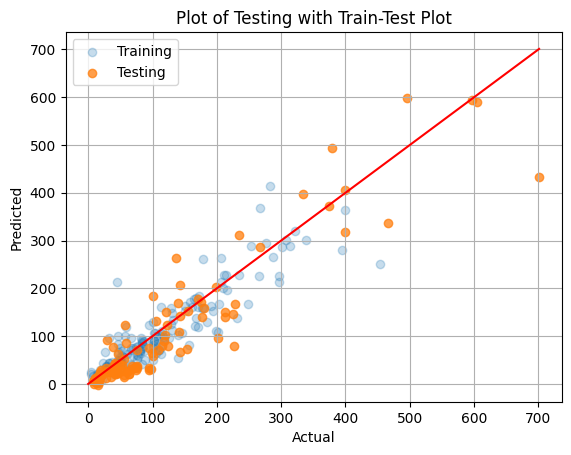

R-squared on Train Data: 0.79850
R-squared on Test Data: 0.85101
RMSE on Train Set: 40.36950701269807
RMSE on Test Set: 52.07209966181157
Mean Absolute Deviation (MAD) on Train Set: 64.9098036703819
Mean Absolute Deviation (MAD) on Test Set: 95.05166415956093


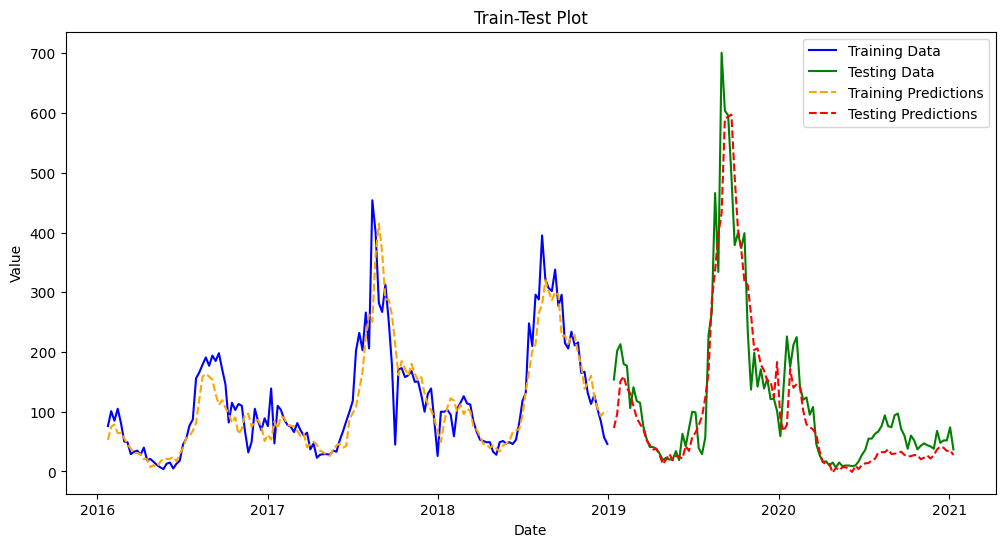

Predictions for location 0 saved to predictions_0.csv


In [ ]:
X_optuna_test = test_df_5_db.drop(columns='cases')
X_optuna_train = train_df_5_db.drop(columns='cases')
y_optuna_test = test_df_5_db[['cases']]
y_optuna_train = train_df_5_db[['cases']]
pipeline = final_model_db

#set_param_recursive(pipeline.steps, 'random_state', 42)
pipeline.fit(X_optuna_train, y_optuna_train)
y_optuna_pred = pipeline.predict(X_optuna_test)

mse = mean_squared_error(y_optuna_test, y_optuna_pred)
mae = mean_absolute_error(y_optuna_test, y_optuna_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_optuna_test, y_optuna_pred)

print(f"All metrics:")
print(f"  MSE CV: {mse}")
print(f"  MAE CV: {mae}")
print(f"  RMSE CV: {rmse}")
print(f"  R2 CV: {r2}")

y_optuna_test = test_df_5_db[['cases', 'loc']]
y_optuna_train = train_df_5_db[['cases', 'loc']]

for location in locations:
    X_loc_train = X_optuna_train[X_optuna_train['loc'] == location]
    y_loc_train = y_optuna_train[y_optuna_train['loc'] == location]
    X_loc_test = X_optuna_test[X_optuna_test['loc'] == location]
    y_loc_test = y_optuna_test[y_optuna_test['loc'] == location]

    y_loc_train = y_loc_train.drop(columns=['loc'])
    y_loc_test = y_loc_test.drop(columns=['loc'])

    pipeline.fit(X_loc_train, y_loc_train)
    y_loc_train_pred = pipeline.predict(X_loc_train)
    y_loc_pred = pipeline.predict(X_loc_test)

    mse = mean_squared_error(y_loc_test, y_loc_pred)
    mae = mean_absolute_error(y_loc_test, y_loc_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_loc_test, y_loc_pred)

    print(f"Location {location} metrics:")
    print(f"  MSE CV: {mse}")
    print(f"  MAE CV: {mae}")
    print(f"  RMSE CV: {rmse}")
    print(f"  R2 CV: {r2}")

    df_loc = df_dbscanned[df_dbscanned['loc'] == location].reset_index()

    plot_pred_vs_actual(X_loc_train, y_loc_train, X_loc_test, y_loc_test, pipeline, 'Train-Test Plot')
    plot_pred_vs_actual_ts(X_loc_train, y_loc_train, X_loc_test, y_loc_test, pipeline, df_loc, 'Train-Test Plot')


    X_loc_test_dated = X_loc_test.reset_index()
    # Save the predictions for each location to the CSV
    loc_predictions_df = pd.DataFrame({
        'date': X_loc_test_dated['date'],
        'loc': location,
        'actual_cases': y_loc_test.values.flatten(),
        'predicted_cases': y_loc_pred.flatten()
    })

    loc_predictions_df.to_csv(f'predictions_{location}.csv', index=False)
    print(f"Predictions for location {location} saved to predictions_{location}.csv")

In [ ]:
def plot_pred_vs_actual(x_train, y_train, x_test, y_test, model, title):

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    max_val = np.max([np.max(y_test), np.max(y_test_pred)])

    plt.plot(np.array([0, max_val]),np.array([0, max_val]),color='r',label='_nolegend_')
    plt.scatter(y_train, y_train_pred, alpha=0.25, label="Training")
    plt.scatter(y_test, y_test_pred, alpha=0.75, label="Testing")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Plot of Testing with {title}')
    plt.legend()
    plt.grid()
    plt.show()


    # R-squared
    print('R-squared on Train Data: %.5f' % model.score(x_train, y_train))
    print('R-squared on Test Data: %.5f' % model.score(x_test,y_test))

    # RMSE
    rmse = mean_squared_error(y_train, y_train_pred)
    print(f"RMSE on Train Set: {np.sqrt(rmse)}")

    rmse = mean_squared_error(y_test, y_test_pred)
    print(f"RMSE on Test Set: {np.sqrt(rmse)}")

    # Calculate MAD
    mean_value = np.mean(y_train_pred)
    abs_deviations = np.abs(y_train_pred - mean_value)
    mad = np.mean(abs_deviations)
    print(f"Mean Absolute Deviation (MAD) on Train Set: {mad}")

    mean_value = np.mean(y_test_pred)
    abs_deviations = np.abs(y_test_pred - mean_value)
    mad = np.mean(abs_deviations)
    print(f"Mean Absolute Deviation (MAD) on Test Set: {mad}")

    return

In [ ]:
def plot_pred_vs_actual_ts(x_train, y_train, x_test, y_test, model, df, title):

    y_train_series = y_train.copy()
    y_test_series = y_test.copy()

    # y_train_series = pd.Series(y_train, index=pd.to_datetime(df.loc[:len(y_train)-1, 'date']))
    # y_test_series = pd.Series(y_test, index=pd.to_datetime(df.loc[len(y_train):len(y_train)+len(y_test)-1, 'date']))

    # Get predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Convert predictions to pandas Series
    y_train_pred_series = pd.Series(y_train_pred, index=y_train_series.index)
    y_test_pred_series = pd.Series(y_test_pred, index=y_test_series.index)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(y_train_series.index, y_train_series, label='Training Data', color='blue')

    # Plot testing data
    plt.plot(y_test_series.index, y_test_series, label='Testing Data', color='green')

    # Plot predictions
    plt.plot(y_train_pred_series.index, y_train_pred_series, label='Training Predictions', linestyle='--', color='orange')
    plt.plot(y_test_pred_series.index, y_test_pred_series, label='Testing Predictions', linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()